In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import *
from tqdm import tqdm
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def P0(alpha, beta):
    return np.exp(-abs(alpha + beta)**2)

def Ptot0(eta,alpha,beta):
    return eta*P0(alpha,beta) + (1-eta)*P0(-alpha,beta)

def Poutcome(n,alpha,beta):
    if n==0.:
        return P0(alpha, beta)
    elif n==1.:
        return 1-P0(alpha,beta)
    else:
        return None
    
def Ptot_outcome(n,eta,alpha,beta):
    if n==0.:
        return Ptot0(eta,alpha, beta)
    elif n==1.:
        return 1.-Ptot0(eta,alpha,beta)
    else:
        return None

def postirior(ot,prior,alpha,beta):
    return prior*Poutcome(ot,alpha,beta)/Ptot_outcome(ot,prior,alpha,beta)

def attenuations(L):
    ats=[np.pi/2]
    for i in range(1,L):
        ats.append(np.arctan(1/np.sqrt(i)))
    return np.array(ats[::-1])

def reward_function(eta):
    return max(eta,1-eta)

In [4]:
def s_function0(beta, alpha, at, eta):
    beta = beta[0]
    s=0
    for n in [0.,1.]:
        s+=Ptot_outcome(n,eta, alpha*np.cos(at), beta)*reward_function(postirior(n, eta, alpha*np.sin(at), beta))
    return 1-s

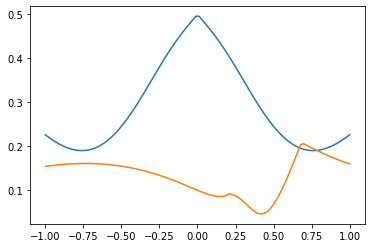

In [5]:
betas = np.linspace(-1,1,100)
ss = [s_function0([b],0.4,np.pi/2,.5) for b in betas]
ss1 = [s_function0([b],0.4,np.pi/2, .1) for b in betas]

plt.plot(betas,ss)
plt.plot(betas,ss1)

In [14]:
N=50
alphas = np.linspace(0,1,N)
etas = np.linspace(0,.5,N)

s0=np.zeros((len(alphas), len(etas)))
fun0=np.zeros((len(alphas), len(etas)))

s1=np.zeros((len(alphas), len(etas)))
fun1=np.zeros((len(alphas), len(etas)))

at=np.pi/2
for inda, a in tqdm(enumerate(alphas)):
    for ine, et in enumerate(etas):
        if inda>0:
            sidi = fun0[inda,ine] +np.random.random()*0.05
        else:
            sidi=0.7
        gf = minimize(s_function0,x0=sidi, args=(a,at,et),bounds= ((None, None))),#method="BFGS",options={"maxiter":1e5,"gtol":1e-7})
        #ff = dual_annealing(s_function0, args=(a,at,et),bounds= tuple([(-1.5,0)]),maxiter=1, no_local_search=False, callback=None)
        
        s0[inda,ine]= 1-ff.fun
        fun0[inda,ine]= ff.x
        
        s1[inda,ine]= 1-gf.fun
        fun1[inda,ine]= gf.x

0it [00:00, ?it/s]


ValueError: length of x0 != length of bounds

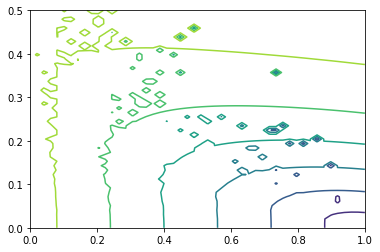

In [7]:
plt.contour(alphas,etas,s0)

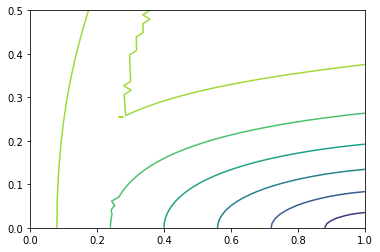

In [8]:
plt.contour(alphas,etas,s1)

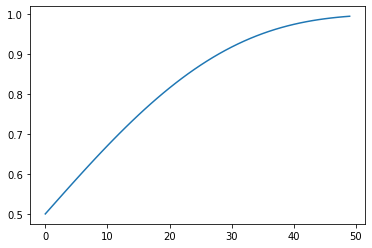

In [9]:
plt.plot(s0[:,49])

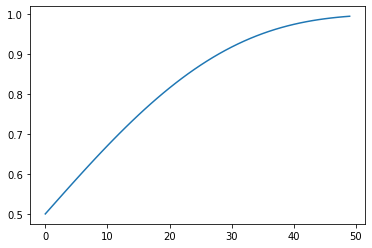

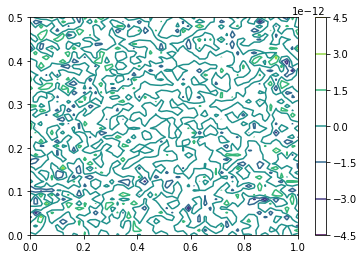

In [10]:
plt.plot(s0[:,49])

from scipy.interpolate import Rbf

alphas1, etas1 = np.meshgrid(alphas,etas)
mod0 = Rbf(etas1,alphas1,s0)

fig=plt.figure()
im = plt.contour(alphas,etas,mod0(etas1,alphas1) - s0)
fig.colorbar(im)


In [11]:
def interpolationn(alpha,eta,rbfint):
    if isinstance(eta,np.ndarray):
        eta = np.where(eta<=.5,eta,1-eta)
        return rbfint(alpha, eta)
    else:
        if eta>.5:
            eta = 1-eta
        return rbfint(alpha,eta)

In [12]:
def s_function1(beta, alpha,at,eta, rbfmod):
    beta = beta[0]
    s=0
    for n in [0.,1.]:
        s+=Ptot_outcome(n,eta, alpha*np.cos(at), beta)*interpolationn(alpha*np.cos(at), postirior(n, eta, alpha*np.sin(at), beta), rbfmod)
    return 1-s

In [13]:
s1=np.zeros((len(alphas), len(etas)))
fun1=np.zeros((len(alphas), len(etas)))

at=np.pi/4
for inda, a in tqdm(enumerate(alphas)):
    for ine, et in enumerate(etas):
        if inda>0:
            sidi = fun1[inda,ine]
        else:
            sidi=0.7
        ff = minimize(s_function1,x0=sidi, args=(a,at,et, mod0),method="BFGS",options={"maxiter":1e4})
        s1[inda,ine]= 1-ff.fun
        fun1[inda,ine]= ff.x

50it [00:29,  1.68it/s]
